In [1]:
#https://github.com/pomber/covid19
print('Initializing São Paulo\'s analysis!')
import numpy as np
import pandas as pd
import folium, html, json
import matplotlib.pyplot as plt
import datetime

Initializing São Paulo's analysis!


In [2]:
df = pd.read_csv('../data/saoPaulo_corona19_data.csv')
df['date'] = df['date'].astype('datetime64[ns]')
df['codigo_ibge'] = df['codigo_ibge'].astype('int') # para tirar o .0
df['codigo_ibge'] = df['codigo_ibge'].astype('str')

today = str(df.date.max().date())
tomorrow = str(df.date.max().date() + datetime.timedelta(days=1))
yesterday = str(df.date.max().date() - datetime.timedelta(days=1))
qtdeMonitored = 5

df.head()

,city,cases,deaths,codigo_ibge,latitude,longitude,date,day,case_day,death_day,%var_case_day,%var_death_day,avg7_cases,avg7_deaths,perc_death,avg7_perc_death
0,aruja,1.0,0.0,3503901,-23.3965,-46.3200,2020-03-26,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0
1,barueri,3.0,0.0,3505708,-23.5057,-46.8790,2020-03-26,1,3,0,0.0,0.0,0.0,0.0,0.0,0.0
2,caieiras,2.0,0.0,3509007,-23.3607,-46.7397,2020-03-26,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0
3,campinas,4.0,0.0,3509502,-22.9053,-47.0659,2020-03-26,1,4,0,0.0,0.0,0.0,0.0,0.0,0.0
4,carapicuiba,2.0,0.0,3510609,-23.5235,-46.8407,2020-03-26,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
state_geo = json.load(open('../data/saoPaulo-cidades.json'))
m = folium.Map(location=[-22.60, -48.44], zoom_start=7)

folium.Choropleth(
    geo_data=state_geo,
    name='Letalidade',
    data=df,
    columns=['codigo_ibge','avg7_perc_death'],
    key_on='feature.properties.codarea',
    highlight=True,
    fill_color='YlOrRd',#'YlGn',
#     ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
    fill_opacity=0.7,
    line_opacity=0.3,
    nan_fill_color = 'white',
    nan_fill_opacity = 0.1,
    legend_name= '% letalidade (media movel 7 ultimos dias)'
).add_to(m)

# for key,estado in df.iterrows():
#     dados = df[df['codigo_ibge']==estado.codigo_ibge]
#     detalhes = '<center><b>'+dados.city.values[0] +'</b></center>\n'
#     detalhes += 'casos: ' + str(dados.cases.values[0]) + ', mortes: ' + str(dados.deaths.values[0])
#     detalhes += ', letalidade: ' + str(dados.perc_death.values[0]) + '%'
# #     detalhes = udetalhes
    
#     folium.CircleMarker(
#         location=[estado.latitude,estado.longitude],
#         radius=2,
# #         popup=detalhes,
#         color='#727b7d',
#         fill=True,
#         fill_color='#ffff',
#         tooltip=detalhes,
#         icon=folium.Icon(color='blue',
#              icon_color='black',
#              icon='info-sign',
#              prefix='es')
#     ).add_to(m)

folium.LayerControl().add_to(m)

m.save('../analysis/maps/saoPauloMapDeaths.html')
m

In [4]:
m = folium.Map(location=[-22.60, -48.44], zoom_start=7)

folium.Choropleth(
    geo_data=state_geo,
    name='Contaminações',
    data=df,
    columns=['codigo_ibge', 'avg7_cases'],
    key_on='feature.properties.codarea',
    fill_color='PuRd',#'YlGn',
    #     ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
    fill_opacity=0.7,
    line_opacity=0.3,
    nan_fill_color = 'white',
    nan_fill_opacity = 0.1,
    legend_name='media movel de casos (7 ultimos dias)'
).add_to(m)

# for key,estado in df.iterrows():
#     dados = df[df['codigo_ibge']==estado.codigo_ibge]
#     detalhes = '<center><b>'+dados.city.values[0] +'</b></center>\n'
#     detalhes += 'casos: ' + str(dados.cases.values[0]) + ', mortes: ' + str(dados.deaths.values[0])
#     detalhes += ', letalidade: ' + str(dados.perc_death.values[0]) + '%'
# #     detalhes = udetalhes
    
#     folium.CircleMarker(
#         location=[estado.latitude,estado.longitude],
#         radius=2,
# #         popup=detalhes,
#         color='#727b7d',
#         fill=True,
#         fill_color='#ffff',
#         tooltip=detalhes,
#         icon=folium.Icon(color='blue',
#              icon_color='black',
#              icon='info-sign',
#              prefix='es')
#     ).add_to(m)

folium.LayerControl().add_to(m)

m.save('../analysis/maps/saoPauloMapCases.html')
m

In [5]:
#https://www.mankier.com/1/wkhtmltoimage#--width
import imgkit
print('Gerando imagens dos mapas de São Paulo')
options = {
    'format': 'png',
#     'crop-h': '3',
#     'crop-w': '3',
#     'crop-x': '3',
#     'crop-y': '3',
    'width':'300',
    'encoding': "UTF-8",
    'custom-header' : [
        ('Accept-Encoding', 'gzip')
    ],
}
imgkit.from_file('../analysis/maps/saoPauloMapDeathsContainer.html', '../analysis/maps/saoPauloMapDeaths.png', options=options)
imgkit.from_file('../analysis/maps/saoPauloMapCasesContainer.html', '../analysis/maps/saoPauloMapCases.png', options=options)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

----------------------------
### São Paulo - Analysis and monitoring

#### Top 10 cities  + Santa Gertrudes

In [6]:
cols = ['city', 'date', 'day','case_day', 'cases', 'death_day', 'deaths', 'avg7_cases', 'avg7_deaths','avg7_perc_death', 'perc_death']
df_top_deaths = df[df['date']==today].sort_values('avg7_perc_death', ascending = False)

df_top_deaths.reset_index(0, inplace=True)
df_top_deaths.index = df_top_deaths.index + 1
df_top_deaths = df_top_deaths[cols].head(qtdeMonitored).append(df_top_deaths[df_top_deaths['city']=='santa gertrudes'][cols]).append(df_top_deaths[df_top_deaths['city']=='lucelia'][cols])
df_top_deaths

,city,date,day,case_day,cases,death_day,deaths,avg7_cases,avg7_deaths,avg7_perc_death,perc_death
1,santo antonio da alegria,2020-04-24,8,0,1.0,0,1.0,0.0,0.0,100.0,100.00
2,caiabu,2020-04-24,14,0,1.0,0,1.0,0.0,0.0,100.0,100.00
3,eldorado,2020-04-24,16,0,1.0,0,1.0,0.0,0.0,100.0,100.00
4,juquitiba,2020-04-24,8,0,1.0,0,1.0,0.0,0.0,100.0,100.00
5,conchas,2020-04-24,11,0,1.0,0,1.0,0.0,0.0,100.0,100.00
143,santa gertrudes,2020-04-24,9,0,1.0,0,0.0,0.0,0.0,0.0,0.00
235,lucelia,2020-04-24,2,1,3.0,0,2.0,0.0,0.0,0.0,66.67


#### Top 10 most transmissible countries + Santa Gertrude + Lucélia - São Paulo

In [7]:
df_top_cases = df[df['date']==today].sort_values('avg7_cases', ascending = False)

df_top_cases.reset_index(0, inplace=True)
df_top_cases.index = df_top_cases.index + 1
df_top_cases = df_top_cases[cols].head(qtdeMonitored).append(df_top_cases[df_top_cases['city']=='santa gertrudes'][cols]).append(df_top_cases[df_top_cases['city']=='lucelia'][cols])
df_top_cases

,city,date,day,case_day,cases,death_day,deaths,avg7_cases,avg7_deaths,avg7_perc_death,perc_death
1,total geral,2020-04-24,9,8455,17826.0,817,1512.0,2045.0,189.0,7.01,8.48
2,sao paulo,2020-04-24,28,575,11800.0,98,1010.0,436.0,52.0,7.58,8.56
3,osasco,2020-04-24,27,16,389.0,4,42.0,23.0,3.0,9.51,10.80
4,sao bernardo do campo,2020-04-24,27,63,421.0,4,29.0,20.0,1.0,6.64,6.89
5,guarulhos,2020-04-24,27,43,399.0,4,46.0,14.0,2.0,9.63,11.53
142,santa gertrudes,2020-04-24,9,0,1.0,0,0.0,0.0,0.0,0.00,0.00
240,lucelia,2020-04-24,2,1,3.0,0,2.0,0.0,0.0,0.00,66.67


#### Cities of São Paulo to be analised

#### Cases and deaths 

In [8]:
#inform the countries you want to analise
monitoredCities = df_top_cases['city'].head(qtdeMonitored).to_numpy()
monitoredCities = np.delete(monitoredCities,np.where([monitoredCities == 'sao paulo'] or [monitoredCities == 'total geral']))
monitoredCities = np.append(monitoredCities,['santa gertrudes','lucelia'])

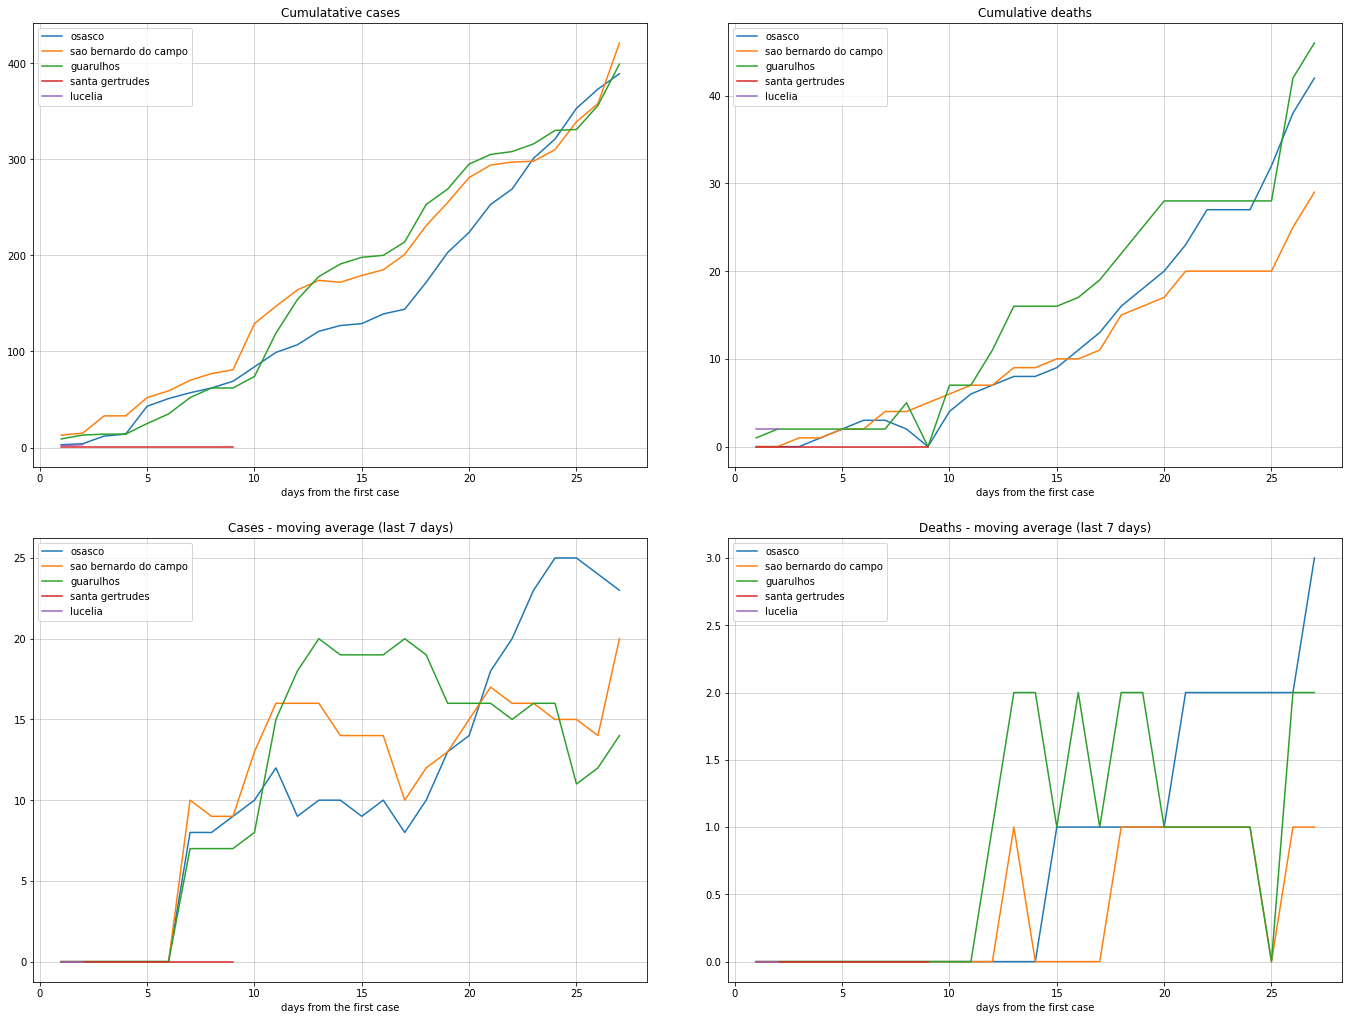

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("Cumulatative cases")
ax1.set_xlabel("days from the first case")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("Cumulative deaths")
ax2.set_xlabel("days from the first case")
ax2.grid(color='gray', alpha = 0.4)

ax3.set_title("Cases - moving average (last 7 days)")
ax3.set_xlabel("days from the first case")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("Deaths - moving average (last 7 days)")
ax4.set_xlabel("days from the first case")
ax4.grid(color='gray', alpha = 0.4)

for city in monitoredCities:
    ax1.plot(df[df['city'] == city].day, df[df['city'] == city].cases, label = city)
    ax2.plot(df[df['city'] == city].day, df[df['city'] == city].deaths, label = city)
    ax3.plot(df[df['city'] == city].day, df[df['city'] == city].avg7_cases, label = city)
    ax4.plot(df[df['city'] == city].day, df[df['city'] == city].avg7_deaths, label = city)
#     ax1.plot(df[df['country'] == country].day, df[df['country'] == country].cases, label = country)
#     ax2.plot(df[df['country'] == country].day, df[df['country'] == country].deaths, label = country)
#     ax3.plot(df[df['country'] == country].day, df[df['country'] == country].avg7_cases, label = country)
#     ax4.plot(df[df['country'] == country].day, df[df['country'] == country].avg7_deaths, label = country)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
fig.savefig('../analysis/saoPaulo_cities_cases_deaths.png')

### Generating the markdown file

In [10]:
f = open('../analysis/README.md', 'w')

readme = '[<img src="data/bandeiras/UK.png" width="30"  /> English version](README_EN.md)'
readme += '\n\n# **Análises e monitoramento**\n'

readme += '\n### Letalidade das cidades do estado de São Paulo\n'
readme += 'O nível de letalidade demonstrado no mapa é definido a partir da média móvel dos últimos 7 dias da letalidade de cada cidade.\n'
readme += '<img src="brazilMap.png" width="100%"  />'
# readme += '[![Clique aqui para o mapa atualizado](brazilMap.png)](brazilMap.html)'

readme += '\n\nEstas análises são relativas aos dados da pandemia Covid19 no estado de São Paulo até a data de **' + today + '**.\n\n'
readme += 'Como existem muitas cidades, colocar em um único gráfico todos seus dados tornaria a leitura e compreensão inviáveis, desta forma, foram selecionadas as ' + str(qtdeMonitored) + ' mais mortais:'
readme += str(monitoredCities) + '.\n\n'
readme += '\n***Dica**: você mesmo pode alterar neste notebook quais cidades você prefere comparar.*\n\n'
readme += '## Top ' + str(qtdeMonitored) + ' cidades mais letais do estado de São Paulo (+ Santa Gertrudes e Lucélia)\n'
readme += df_top_deaths.to_markdown()
# readme += tabulate(df_top_deaths.values,df_top_deaths.columns, tablefmt="pipe")
readme += '\n\n\n ## Top ' + str(qtdeMonitored) + ' cidades mais transmissíveis do estado de São Paulo (+ Santa Gertrudes e Lucélia)\n'
readme += df_top_cases.to_markdown()
#tabulate(df_top_cases.values,df_top_cases.columns, tablefmt="pipe")

readme += '\n----------------------\n'
readme += '## Casos e mortes\n'
readme += '![](saoPaulo_cities_cases_deaths.png)'

readme += '\n\n [Comparativos do estado de São Paulo com outros estados do Brasil podem ser encontratos aqui.](README.md#an%C3%A1lises-do-brasil)'

f.write(readme)
f.close()

###########################################

f = open('../analysis/README_EN.md', 'w')

readme = '[<img src="data/bandeiras/PT.png" width="30"   />Versão em português](README.md)'

readme += '\n\n# **Analysis and monitoring**\n'

readme += '\n### Lethality of the San Paulo\'s cities\n'
readme += 'The lethality level shown in this map is defined from the moving average of the last 7 days of each city lethality of the San Paulo state.\n'
readme += '<img src="saoPauloMapDeaths.png" width="100%"  />'

readme += '\n### Transmission of the San Paulo\'s cities\n'
readme += 'The tranmission level shown in this map is defined from the moving average of the last 7 days of each city\'s cumulative cases.\n'
readme += '<img src="saoPauloMapCases.png" width="100%"  />'

readme += '\n\nThese analysis are related to state of San Paulo Convid19 pandemic data up to **' + today + '**.\n\n'
readme += 'As there are too many cities to have their data plotted together, were selected the ' + str(qtdeMonitored) + ' deadliest:'
readme += str(monitoredCities) + '.\n\n'
readme += '\n***Tip**: you can yourself select in this notebook which states you prefer to compare.*\n\n'
readme += '## Top ' + str(qtdeMonitored) + ' deadliest cities of the state of San Paulo (+ Santa Gertrudes and Lucelia cities) of Brazil\n'
readme += df_top_deaths.to_markdown()
# readme += tabulate(df_top_deaths.values,df_top_deaths.columns, tablefmt="pipe")
readme += '\n\n\n ## Top ' + str(qtdeMonitored) + ' most transmissible cities of state of San Paulo (+ Santa Gertrudes and Lucelia cities)\n'
readme += df_top_cases.to_markdown()
#tabulate(df_top_cases.values,df_top_cases.columns, tablefmt="pipe")

readme += '\n----------------------\n'
readme += '## Cases and deaths\n'
readme += '![](saoPaulo_cities_cases_deaths.png)'

readme += '\n\n [Comparison of San Paulo among other Brazilian states can be found here.](README_EN.md#brazils-analysis)'
f.write(readme)
f.close()
print('São Paulo\'s analysis done!')

São Paulo's analysis done!


In [11]:
# df[df['state']=='SP'][['date','death_day']]